# Verification results notebook
This notebook can optionally run a batch of tests in which all the selected implementations across backends and possibly devices are compared against a reference implementation on a distribution of initial conditions.

I decided to include the test runs inside the notebook. This way I can:
  * control the experiments from a single source of truth
  * put in the same file the generation of the dataset and its processing (although the generation could be "cached")
  * possibly connect with remote devices (with Jupyter remote server) and collect interesting data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# these are the columns of the dataset we will study
COLUMNS = [
    'algorithm',
    'name',
    'backend',
    'device',
    'dtype',
    'seed',
    'abs_err',
    'rel_err',
    'transfer_time',
    'compute_time',
]

## Test runner implementation

In [3]:
import jax
import jax.numpy as jnp
jax.config.update('jax_enable_x64', True)
import numpy as np

from slmporting.core.slm import SLM
from slmporting.core.array import Array
from slmporting.core.types import Algorithm, Backend, Device, DType

In [4]:
# functions to manage the rng state, the user initializes the rng from an integer
# these functions must be exported because other experiments share the same functionality
def key_to_int(key):
    """Combine two uint32 values into a single 64-bit integer seed."""
    return int(key[0]) << 32 | int(key[1])


def int_to_key(seed):
    """Recreate the PRNGKey from the integer seed."""
    upper = (seed >> 32) & 0xFFFFFFFF
    lower = seed & 0xFFFFFFFF
    return jnp.array([upper, lower], dtype=jnp.uint32)


def generate_input_data(key, n: int):
    key, subkey = jax.random.split(key)
    subkeys = jax.random.split(subkey, 4)

    x     = Array(jax.random.uniform(subkeys[0], n, minval=-50.0, maxval=50.0))
    y     = Array(jax.random.uniform(subkeys[1], n, minval=-50.0, maxval=50.0))
    z     = Array(jax.random.uniform(subkeys[2], n, minval=-5.0 , maxval=5.0))
    pists = Array(jax.random.uniform(subkeys[3], n, minval=0.0  , maxval=1.0))

    return (key, subkey), (x, y, z, pists)

In [5]:
import itertools
import slmporting.impl.impl_numpy
import slmporting.impl.impl_jax
import slmporting.impl.impl_torch
import slmporting.impl.impl_cpp

# function for filtering the implementations based on
#   * requested backends
#   * requested devices
def filter_implementations(
        requested_algorithm: list,
        requested_backends: list):

    def filter_fcn(impl):
        return (impl.backend in requested_backends) and \
               (impl.algorithm in requested_algorithm)

    all_implementations = itertools.chain(
        slmporting.impl.impl_numpy.IMPLS,
        slmporting.impl.impl_jax.IMPLS,
        slmporting.impl.impl_torch.IMPLS,
        slmporting.impl.impl_cpp.IMPLS,
    )

    return list(filter(filter_fcn, all_implementations))

In [6]:
# we are dealing with a number that lives in [0, 2π]
# and wraps, so 2π-ε and ε are quite close
def abs_error_function(x, y):
    return np.max(np.abs(x-y))

def rel_error_function(x, y):
    return np.max(np.abs((x-y)/x))

In [7]:
from tqdm.notebook import tqdm

# this test is made only for CPU devices,
# but it should be extended for GPU use
def run_test_batch(
    seed: int,
    nruns: int,
    requested_backends = [
        Backend.NUMPY,
        Backend.JAX,
        Backend.TORCH,
        Backend.CPP,
    ],
    nspots: int = 100) -> pd.DataFrame:

    key = int_to_key(seed)
    slm = SLM.get_standard_slm()

    algorithm = Algorithm.RS
    matching_implementations = [
        impl()
        for impl in filter_implementations(
            [algorithm],
            requested_backends,
        )
    ]
    assert(len(matching_implementations) > 0)

    # the structure where I push the experiment data,
    # to be later transformed into a pandas dataframe
    acc = []

    for run_idx in tqdm(range(nruns)):
        (key, subkey), (x, y, z, pists) = generate_input_data(key, nspots)

        reference_impl = matching_implementations[0]
        reference_phase, _ = reference_impl(x, y, z, pists, slm)

        for impl in matching_implementations:
            assert(impl.algorithm == algorithm)
            alternative_phase, times = impl(x, y, z, pists, slm)

            total_time = times.transfer_time + times.compute_time

            acc.append((
                algorithm,
                impl.name,
                impl.backend,
                Device.CPU,
                DType.fp64,
                key_to_int(key),
                abs_error_function(reference_phase, alternative_phase),
                rel_error_function(reference_phase, alternative_phase),
                times.transfer_time,
                times.compute_time
            ))

    return pd.DataFrame(acc, columns=COLUMNS)

## Optional test execution

This notebook is meant to be executed on:
  * my working laptop
  * a google colab environment
  * my computing cluster

I propose the use of environment variables that override the notebook execution parameters. This way I can remotely execute a complete notebook without any manual intervention. This is a snippet for starting an asynchronous jupyter notebook:

```bash
nohup jupyter nbconvert --to notebook --execute verification.ipynb --output result.ipynb > notebook.log 2>&1 &
```

In [8]:
import os

def get_notebook_execution_parameters(
    csv_filename: str,
    seed: int,
    nruns: int,
):
    csv_filename = os.environ.get('SLM_OUTPUT_CSV') or csv_filename
    seed = os.environ.get('SLM_SEED') or seed
    nruns = os.environ.get('SLM_NRUNS') or nruns

    return csv_filename, seed, nruns

In [9]:
csv_filename, seed, nruns = get_notebook_execution_parameters(
    csv_filename='results/hp_laptop.csv',
    seed=99,
    nruns=100
)

In [10]:
try:
    df = pd.read_csv(csv_filename)
except FileNotFoundError:
    df = run_test_batch(seed, nruns)
    df.to_csv(csv_filename, index=False)

## Data analysis

### Preprocessing

In [11]:
df['total_time'] = df['transfer_time'] + df['compute_time']

In [12]:
# those columns are enums, not strings. I convert them into strings
# so that the further processing follows a more traditional workflow
for column_name in ['algorithm', 'backend', 'device', 'dtype']:
    df[column_name] = df[column_name].apply(
        lambda a: str(a).split('.')[-1]
    )

In [13]:
backend_color_map = {
    'NUMPY': '#568df5',
    'JAX': '#52fa85',
    'TORCH': '#fa6b52',
    'CPP': '#2617ff'
}

In [14]:
# In the following analyses I need to group the data by backend
# and then by implementation name.
grouped_by_backend = df.groupby('backend')

In [15]:
df.head(n=10)

,algorithm,name,backend,device,dtype,seed,abs_err,rel_err,transfer_time,compute_time,total_time
0,RS,rs,NUMPY,CPU,fp64,10350481614395321474,0.000000e+00,0.000000e+00,0.000132,0.563160,0.563293
1,RS,rs_no_complex,NUMPY,CPU,fp64,10350481614395321474,4.440892e-16,3.936921e-16,0.000179,0.450990,0.451169
2,RS,rs,JAX,CPU,fp64,10350481614395321474,3.167910e-12,1.714339e-09,0.000586,0.167671,0.168258
3,RS,rs_no_complex,JAX,CPU,fp64,10350481614395321474,3.167910e-12,1.714339e-09,0.000894,0.336545,0.337439
4,RS,rs_vmap,JAX,CPU,fp64,10350481614395321474,3.013589e-12,2.272637e-09,0.000534,0.210408,0.210942
5,RS,rs,TORCH,CPU,fp64,10350481614395321474,1.247891e-13,6.095896e-12,0.000176,1.943525,1.943701
6,RS,rs_no_complex,TORCH,CPU,fp64,10350481614395321474,5.417888e-14,6.095730e-12,0.000274,0.152222,0.152496
7,RS,rs,CPP,CPU,fp64,10350481614395321474,3.027800e-12,2.151268e-09,0.000261,0.023109,0.023370
8,RS,rs_simd,CPP,CPU,fp64,10350481614395321474,5.399237e-12,4.612056e-10,0.000234,0.022460,0.022695
9,RS,rs_simulated_simd,CPP,CPU,fp64,10350481614395321474,3.142819e-12,2.221056e-09,0.000293,0.066152,0.066444


### Aggregate information

In [16]:
def aggregate_df(df):
    acc = []
    for backend, local in df.groupby('backend'):
        for name, local_local in local.groupby('name'):
            acc.append((
                backend,
                name,
                np.median(local_local['abs_err']),
                np.median(local_local['rel_err']),
                np.median(local_local['total_time']),
            ))

    return pd.DataFrame(
        acc,
        columns=[
            'backend',
            'name',
            'median_abs_err',
            'median_rel_err',
            'median_total_time'
        ]
    )

In [17]:
df_median = aggregate_df(df)
display(df_median)

,backend,name,median_abs_err,median_rel_err,median_total_time
0,CPP,rs,2.401634e-12,6.133656e-10,0.025429
1,CPP,rs_simd,2.221306e-12,5.810007e-10,0.035222
2,CPP,rs_simulated_simd,2.370548e-12,6.334117e-10,0.104231
3,JAX,rs,2.256258e-12,5.630036e-10,0.121592
4,JAX,rs_no_complex,2.256258e-12,5.630036e-10,0.326838
5,JAX,rs_vmap,2.452580e-12,5.505753e-10,0.169506
6,NUMPY,rs,0.000000e+00,0.000000e+00,0.588221
7,NUMPY,rs_no_complex,4.440892e-16,3.985499e-16,0.505858
8,TORCH,rs,8.737455e-14,2.231903e-11,0.311854
9,TORCH,rs_no_complex,2.298162e-14,2.909457e-12,0.104499


### Error distribution
Considering only CPU implementations:
  * what is the distribution of the error, among the backends and the single implementations?
  * are there any outliers in the error?
  * what is the most precise implementation for each backend?

In [18]:
def grouped_boxplot(grouped, column: str, ylabel: str, fn = (lambda x: x), ylim=None):
    bar_width = 0.2
    intra_gap = 0.05
    group_gap = 0.6

    fig, ax = plt.subplots()

    offset = 0.0
    x_positions = []
    x_labels = []

    for backend, local in grouped:
        color = backend_color_map[backend]

        for name in local['name'].unique():
            ax.boxplot(
                fn(local[column][local['name'] == name]),
                positions=[offset],
                widths=bar_width,
                patch_artist=True,
                boxprops=dict(facecolor=color, color='black'),
                medianprops=dict(color=color)
            )

            x_positions.append(offset)
            x_labels.append(name)
            offset += bar_width + intra_gap

        offset += group_gap

        ax.bar(0, 0, color=color, label=backend)

    ax.set_title(f'`{column}` distribution for each backend')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=65, ha='right')
    ax.set_ylim(ylim)
    ax.set_ylabel(ylabel)
    ax.legend(title="Backend")

    plt.tight_layout()
    plt.show()

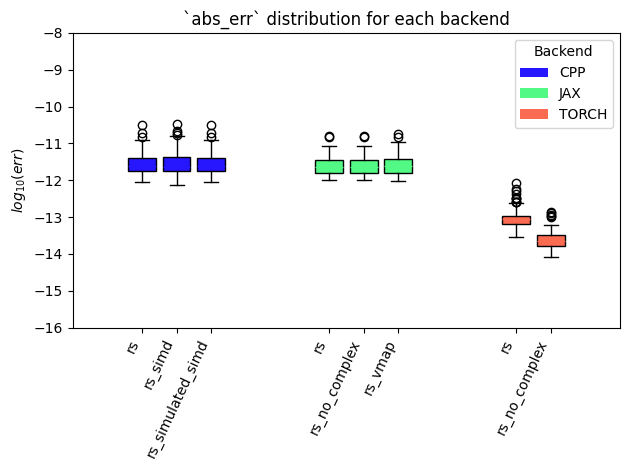

In [19]:
grouped_by_backend_without_numpy = df[
    (df['backend'] != 'NUMPY') &
    (df['device'] == 'CPU')
].groupby('backend')

grouped_boxplot(
    grouped_by_backend_without_numpy,
    column = 'abs_err',
    ylabel = '$log_{10}(err)$',
    ylim=(-16.0,-8.0),
    fn=np.log10
)

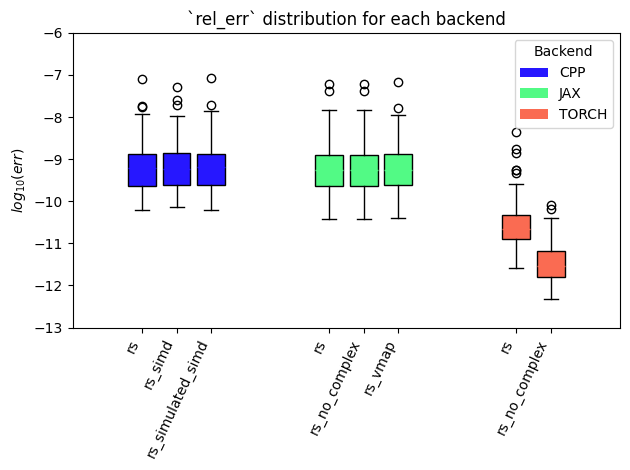

In [20]:
grouped_boxplot(
    grouped_by_backend_without_numpy,
    column = 'rel_err',
    ylabel = '$log_{10}(err)$',
    ylim=(-13.0,-6.0),
    fn=np.log10
)

The numpy implementation was the reference in this experiment, so it's normal that its absolute error is the lowest. The other implementations could have introduced errors by:
  * calling lower precision variants of trigonometric functions
  * implementing a different reduction strategy for the plus operator

The phase is uniformely distributed in $[0, 2 \pi]$ so this kind of errors don't scare me. This is primarely a test for buggy implementations and fortunately there are no outliers here.

### Performance
The data campaign doesn't specifically test for performance as it will be very wasteful to profile a known bad implementation. From this data we can screen for the best implementation in each category, then we can inform more accurate test pipelines.

We can reuse the same grouped comparison plots for the runtime plots. Speedup plots are required.

In [21]:
local = df[
    (df['algorithm'] == 'RS') &
    (df['device'] == 'CPU') &
    (df['dtype'] == 'fp64')
]

In [22]:
grouped_by_backend = local.groupby('backend')

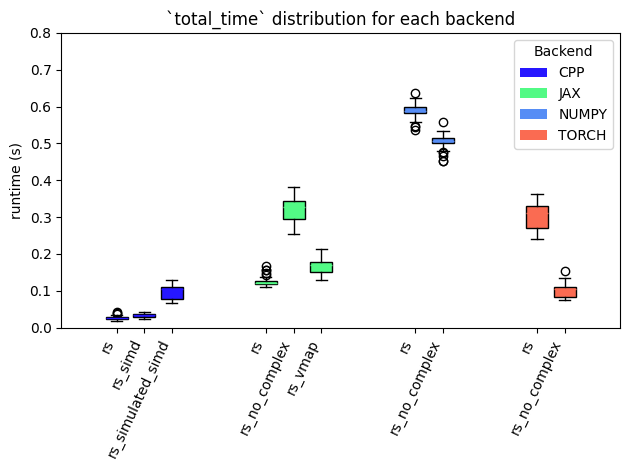

In [23]:
grouped_boxplot(
    grouped_by_backend,
    column = 'total_time',
    ylabel = 'runtime (s)',
    ylim = (0.0, 0.8),
)

The big variability in the torch version of `rs` is due to:
  * JIT compilation
  * torch non fully supporting complex numbers operations

This has been tested across 4 different consumer hardwares and my C++ implementations consistently beat the pytorch one by at least a factor of 2. We suspect the torch compiled version doesn't fully use vectorized instructions.

In [24]:
df_cpu_aggregate = aggregate_df(local)
best_runtime_per_backend = df_cpu_aggregate.loc[df_median.groupby('backend')['median_total_time'].idxmin()]
display(best_runtime_per_backend)

,backend,name,median_abs_err,median_rel_err,median_total_time
0,CPP,rs,2.401634e-12,6.133656e-10,0.025429
3,JAX,rs,2.256258e-12,5.630036e-10,0.121592
7,NUMPY,rs_no_complex,4.440892e-16,3.985499e-16,0.505858
9,TORCH,rs_no_complex,2.298162e-14,2.909457e-12,0.104499


In [25]:
def plot_speedup_to_x(aggregate, x: str):
    baseline = aggregate.loc[aggregate['backend'] == x]['median_total_time'].to_numpy()
    speedup_to_x = baseline / aggregate['median_total_time'].to_numpy()

    fig, ax = plt.subplots()

    bars = ax.bar(
        aggregate['backend'],
        speedup_to_x,
        color=[
            backend_color_map[b]
            for b in aggregate['backend']
        ],
    )

    ax.set_title(f"Speedup to {x} ({csv_filename})")
    ax.set_ylabel('speedup')

    ax.bar_label(
        bars,
        labels=[f"{v:.1f}x" for v in speedup_to_x],
        padding=1
    )

    plt.show()

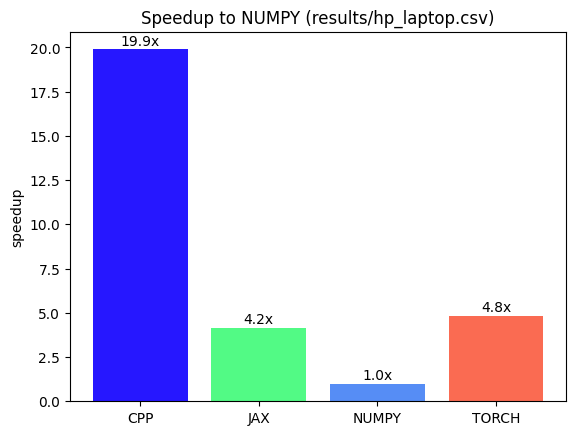

In [26]:
plot_speedup_to_x(best_runtime_per_backend, 'NUMPY')

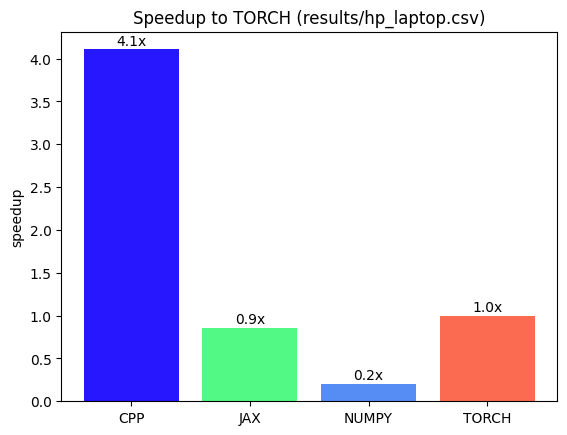

In [27]:
plot_speedup_to_x(best_runtime_per_backend, 'TORCH')